In [22]:
from multiprocessing import Pool,sharedctypes
from functools import partial
from contextlib import closing
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import h5py as h5
import os
import sys
import skymapper as skm
import matplotlib.cm as cm
import matplotlib
import copy

In [2]:
def getHealpixCoords(pixels, nside, nest=False):
    # convert healpix cell indices to center ra/dec
    import healpy as hp
    theta, phi = hp.pix2ang(nside, pixels, nest=nest)
    return phi * 180. / np.pi, 90 - theta * 180. / np.pi


def log_skm_plot(mapa, mask, sep=15, ra = None, dec = None, richness = None, title = None, add_rmp = True, small_scale = False, cb_label = 'number density [n_gal/arcmin$^2$]', x_size = 6, y_size = 6, vmin = -0.01, vmax = 0.01):
    cmap = cm.RdYlBu_r
    fig = plt.figure(figsize=(x_size,y_size))
    ax = fig.add_subplot(111, aspect='equal')
       
    reticule = sep
    nside = hp.pixelfunc.npix2nside(len(mapa))
    pixels = np.array(range(len(mapa)))
    pixels = pixels[~mask]
    print(pixels)
    ra_, dec_ = getHealpixCoords(pixels, nside)

    # setup map: define AEA map optimal for given RA/Dec
    #proj = skm.createConicMap(ax, ra_, dec_, proj_class=skm.AlbersEqualAreaProjection)
    crit = skm.stdDistortion
    proj = skm.Albers.optimize(ra_, dec_, crit=crit)
    # add lines and labels for meridians/parallels (separation 5 deg)
    
    parallels = np.arange(0. ,360., reticule)
    meridians = np.arange(-90., 90., reticule)
    # convert to map coordinates and plot a marker for each point
    x,y = proj(ra_, dec_)
    marker = 's'
    #markersize = skm.getMarkerSizeToFill(fig, ax, x, y)
    #s=markersize,
    sc = ax.scatter(x,y, c=mapa[pixels], edgecolors='None', marker=marker, s=2,  cmap=cmap, vmin=vmin, vmax=vmax, rasterized=True, zorder=1,
                norm=matplotlib.colors.LogNorm())
    xlabels=ax.get_xticks()
    ylabels=ax.get_yticks()
    print(xlabels,ylabels)
    #ax.set_xticklabels(ra_,dec_)
    #ax.set_xticklabels(map(str, ax.get_xticks()/5.0))
    #labels=getHealpixCoords(labels, nside)
    #print(labels)

    # overplot with another data set
    # here clusters [not implemented]
    if add_rmp:
        x,y = proj(ra, dec)
        ax.scatter(x,y, c='None', edgecolors='k', linewidths=1, s=richness, marker='o', zorder=3)
    if title:
        plt.title(title)

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes("right", size="2%", pad=0.3)
    cb = fig.colorbar(sc, cax=cax )
    if cb_label != None:
        cb.set_label(cb_label)
    ticks = np.linspace(vmin, vmax, 5)
    cb.set_ticks(ticks)
    if small_scale:
        cb.set_ticklabels([('%.1f' % (t))   for t in ticks])       
    else:
        cb.set_ticklabels([('%.1f' % (t))   for t in ticks])
    cb.solids.set_edgecolor("face")
    fig.show()

    
def skm_plot(mapa, mask, sep=15, ra = None, dec = None, richness = None, title = None, add_rmp = True, small_scale = False, cb_label = 'number density [n_gal/arcmin$^2$]', x_size = 6, y_size = 6, vmin = -0.01, vmax = 0.01):
    cmap = cm.RdYlBu_r
    fig = plt.figure(figsize=(x_size,y_size))
    ax = fig.add_subplot(111, aspect='equal')
       
    reticule = sep
    nside = hp.pixelfunc.npix2nside(len(mapa))
    pixels = np.array(range(len(mapa)))
    pixels = pixels[~mask]
    ra_, dec_ = getHealpixCoords(pixels, nside)

    # setup map: define AEA map optimal for given RA/Dec
    crit = skm.stdDistortion
    proj = skm.Albers.optimize(ra_, dec_, crit=crit)
    # add lines and labels for meridians/parallels (separation 5 deg)
    
    parallels = np.arange(0. ,360., reticule)
    meridians = np.arange(-90., 90., reticule)
    # convert to map coordinates and plot a marker for each point
    x,y = proj(ra_, dec_)
    marker = 's'

    sc = ax.scatter(x,y, c=mapa[pixels], edgecolors='None', marker=marker, s=2,  cmap=cmap, vmin=vmin, vmax=vmax, rasterized=True, zorder=1)

    # overplot with another data set
    if add_rmp:
        x,y = proj(ra, dec)
        ax.scatter(x,y, c='None', edgecolors='k', linewidths=1, s=richness, marker='o', zorder=3)
    if title:
        plt.title(title)

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes("right", size="2%", pad=0.3)
    cb = fig.colorbar(sc, cax=cax )
    if cb_label != None:
        cb.set_label(cb_label)
    ticks = np.linspace(vmin, vmax, 5)
    cb.set_ticks(ticks)
    if small_scale:
        cb.set_ticklabels([('%.1f' % (t))   for t in ticks])       
    else:
        cb.set_ticklabels([('%.1f' % (t))   for t in ticks])
    cb.solids.set_edgecolor("face")
    fig.show()

    

In [3]:
bins = ['all']
nside = 1024
def convert_to_pix_coord(ra, dec, nside=1024):
    """
    Converts RA,DEC to hpix coordinates
    """
    theta = (90.0 - dec) * np.pi / 180.
    phi = ra * np.pi / 180.
    pix = hp.ang2pix(nside, theta, phi, nest=False)
    return pix
print 'done' 

done


# Read data

In [ ]:

# read File *******
File_data = "/global/cscratch1/sd/troxel/cats_des_y3/Y3_mastercat_03_16_20_highsnr.h5"
#"/project/projectdirs/des/www/y3_cats/Y3_mastercat_12_3_19.h5"
master = h5.File(File_data,'r')

# load selections ********************************
select_metacal  = np.array(master['index']['select_shape']) # gold + mcal
select_all  = np.array(master['index']['select'])  # photo + gold + mcal
select_metacal_1p  = np.array(master['index']['select_shape_1p'])
select_metacal_1m  = np.array(master['index']['select_shape_1m'])
select_metacal_2p  = np.array(master['index']['select_shape_2p'])
select_metacal_2m  = np.array(master['index']['select_shape_2m'])
select_all_1p  = np.array(master['index']['select_1p'])
select_all_1m  = np.array(master['index']['select_1m'])
select_all_2p  = np.array(master['index']['select_2p'])
select_all_2m  = np.array(master['index']['select_2m'])

# load weights *************************************
w = np.array(master['catalog']['metacal']['unsheared']['weight'])
w1p = np.array(master['catalog']['metacal']['sheared_1p']['weight'])
w2p = np.array(master['catalog']['metacal']['sheared_1m']['weight'])
w1m = np.array(master['catalog']['metacal']['sheared_2p']['weight'])
w2m = np.array(master['catalog']['metacal']['sheared_2m']['weight'])

snr = np.array(master['catalog']['metacal']['unsheared']['snr'])
size_ratio =  np.array(master['catalog']['metacal']['unsheared']['size_ratio'])

ra_master = np.array(master['catalog']['metacal']['unsheared']['ra'])
dec_master =  np.array(master['catalog']['metacal']['unsheared']['dec'])

e1 = np.array(master['catalog']['metacal']['unsheared']['e_1'])#[select_all]
e2 = np.array(master['catalog']['metacal']['unsheared']['e_2'])#[select_all]
e1p = np.array(master['catalog']['metacal']['sheared_1p']['e_1'])#[select_metacal]
e1m = np.array(master['catalog']['metacal']['sheared_1m']['e_1'])#[select_metacal]
e2p = np.array(master['catalog']['metacal']['sheared_2p']['e_2'])#[select_metacal]
e2m = np.array(master['catalog']['metacal']['sheared_2m']['e_2'])#[select_metacal]
w = np.array(master['catalog']['metacal']['unsheared']['weight'])

# compute response:  **********************
dgamma = 2. * 0.01
R11_1_metacal = (np.mean(e1p[select_metacal]) - np.mean(e1m[select_metacal]) + np.mean(
e1[select_metacal_1p]) - np.mean(
e1[select_metacal_1m]))/ dgamma
R22_1_metacal = (np.mean(e2p[select_metacal]) - np.mean(e2m[select_metacal]) + np.mean(
e2[select_metacal_2p]) - np.mean(
e2[select_metacal_2m])) / dgamma
print R11_1_metacal
print R22_1_metacal

R11_1_all = (np.mean(e1p[select_all]) - np.mean(e1m[select_all]) + np.mean(
e1[select_all_1p]) - np.mean(
e1[select_all_1m]))/ dgamma
R22_1_all = (np.mean(e2p[select_all]) - np.mean(e2m[select_all]) + np.mean(
e2[select_all_2p]) - np.mean(
e2[select_all_2m])) / dgamma
print R11_1_all
print R22_1_all



# compute response weighted *************: 
dgamma = 2. * 0.01
R11_1_metacal_w = (np.sum((w1p*e1p)[select_metacal])/np.sum((w1p)[select_metacal])
                   - np.sum((w1m*e1m)[select_metacal])/np.sum((w1m)[select_metacal]) + 
                   np.sum((e1*w)[select_metacal_1p])/np.sum(w[select_metacal_1p]) -
                   np.sum((e1*w)[select_metacal_1m])/np.sum((w)[select_metacal_1m]))/ dgamma
R22_1_metacal_w = (np.sum((w2p*e2p)[select_metacal])/np.sum((w2p)[select_metacal])
                   - np.sum((w2m*e2m)[select_metacal])/np.sum((w2m)[select_metacal]) + 
                   np.sum((e2*w)[select_metacal_2p])/np.sum(w[select_metacal_2p]) -
                   np.sum((e2*w)[select_metacal_2m])/np.sum((w)[select_metacal_2m]))/ dgamma

print R11_1_metacal_w
print R22_1_metacal_w

R11_1_all_w = (np.sum((w1p*e1p)[select_all])/np.sum((w1p)[select_all])
                   - np.sum((w1m*e1m)[select_all])/np.sum((w1m)[select_all]) + 
                   np.sum((e1*w)[select_all_1p])/np.sum(w[select_all_1p]) -
                   np.sum((e1*w)[select_all_1m])/np.sum((w)[select_all_1m]))/ dgamma
R22_1_all_w = (np.sum((w2p*e2p)[select_all])/np.sum((w2p)[select_all])
                   - np.sum((w2m*e2m)[select_all])/np.sum((w2m)[select_all]) + 
                   np.sum((e2*w)[select_all_2p])/np.sum(w[select_all_2p]) -
                   np.sum((e2*w)[select_all_2m])/np.sum((w)[select_all_2m]))/ dgamma
print R11_1_all_w
print R22_1_all_w



# n_eff

n_eff:  6.022621294403331
optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.98675723800992,-35.86924773198294,-57.27828260783114,-11.344402695166536)


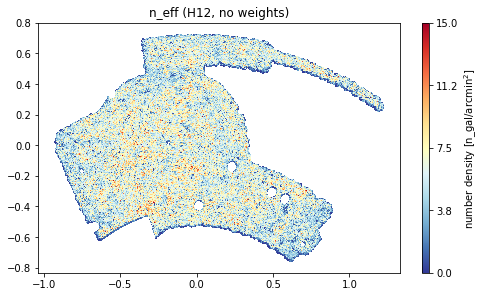

/global/u2/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in divide


n_eff:  5.001674514436137
optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.98675723800992,-35.86924773198294,-57.27828260783114,-11.344402695166536)


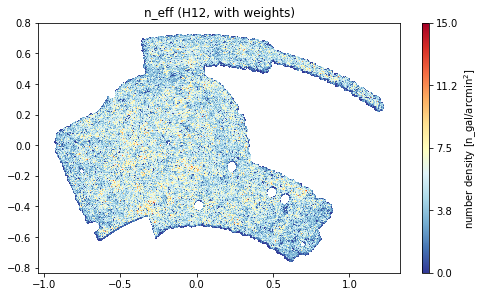

In [36]:
sizz = 7 # size plots 
sel_label = 'metacal' #or all

if sel_label == 'metacal':
    selection_mask = copy.copy(select_metacal)
elif sel_label == 'all':
    selection_mask = copy.copy(select_all)

if not os.path.exists('./figures_maps/'):
    os.mkdir('./figures_maps/')
#neff map ******************
desy3_map = np.zeros(hp.nside2npix(nside))
pix1 = convert_to_pix_coord(ra_master[selection_mask],dec_master[selection_mask], nside=nside)

unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
desy3_map[unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(pix1)))
mas_desy3 = desy3_map!=0.
res = desy3_map/(hp.pixelfunc.nside2pixarea(nside,degrees=True)*(60*60)) #/R_ave
print 'n_eff: ',np.mean(res[mas_desy3])
skm_plot(res, ~mas_desy3 , sep=15 , title = 'n_eff (H12, no weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, vmin = 0, vmax = 15,small_scale='True')
plt.savefig('./figures_maps/number_density.pdf')
plt.show()

#neff map with weights ******************

# def heymans: 1/Area sum(w)**2 / sum (w**2)
desy3_map_w = np.zeros(hp.nside2npix(nside))
desy3_map_w2 = np.zeros(hp.nside2npix(nside))

pix1 = convert_to_pix_coord(ra_master[selection_mask],dec_master[selection_mask], nside=nside)

unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
desy3_map_w[unique_pix1] += np.bincount(idx_rep1, weights=w[selection_mask])
desy3_map_w2[unique_pix1] += np.bincount(idx_rep1, weights=w[selection_mask]**2)

res_w = desy3_map_w**2/desy3_map_w2/(hp.pixelfunc.nside2pixarea(nside,degrees=True)*(60*60)) #/R_ave
print 'n_eff: ',np.mean(res_w[mas_desy3])
skm_plot(res_w, ~mas_desy3 , sep=15 , title = 'n_eff (H12, with weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, vmin = 0, vmax = 15,small_scale='True')
plt.savefig('./figures_maps/number_density_H12.pdf')
plt.show()

# weight

23.744055520058886
32.43762565368607
[ 5695852  5695853  5695854 ... 12117619 12117620 12117621]
optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.98675723800992,-35.86924773198294,-57.27828260783114,-11.344402695166536)
(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


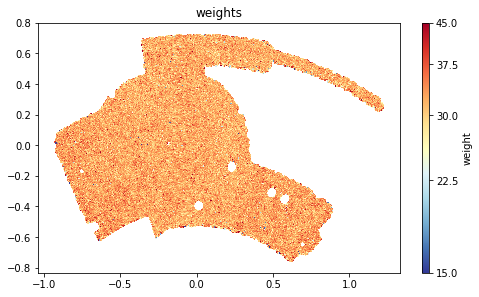

In [43]:
sizz = 7 # size plots 
sel_label = 'metacal' #or all

if sel_label == 'metacal':
    selection_mask = copy.copy(select_metacal)
elif sel_label == 'all':
    selection_mask = copy.copy(select_all)

print(np.mean(w))

w_map = np.zeros(hp.nside2npix(nside))
pix1 = convert_to_pix_coord(ra_master[selection_mask],dec_master[selection_mask], nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
w_map[unique_pix1] += np.bincount(idx_rep1, weights=w[selection_mask])

mas_desy3 = desy3_map!=0.
w_map[mas_desy3] = w_map[mas_desy3]/desy3_map[mas_desy3]
print(np.mean(w_map[mas_desy3]))
log_skm_plot(w_map, ~mas_desy3 , sep=15 , title = 'weights',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'weight', vmin = 15, vmax = 45,small_scale='True')
plt.savefig('./figures_maps/weight.pdf')

# snr

-5.311336304771523
72.80758281813635
[ 5695852  5695853  5695854 ... 12117619 12117620 12117621]
optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.98675723800992,-35.86924773198294,-57.27828260783114,-11.344402695166536)
(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))
52.24675495309531
51.639687342958844
[ 5695852  5695853  5695854 ... 12117619 12117620 12117621]
optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.98675723800992,-35.86924773198294,-57.27828260783114,-11.344402695166536)
(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


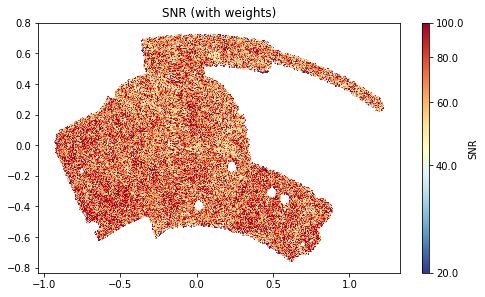

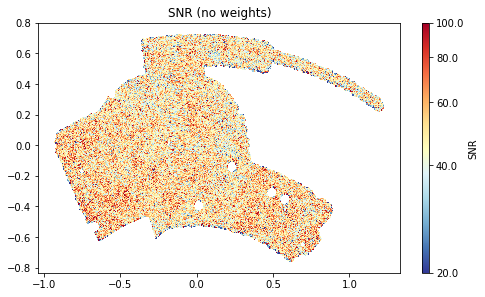

In [45]:
sizz = 7 # size plots 
sel_label = 'metacal' #or all

if sel_label == 'metacal':
    selection_mask = copy.copy(select_metacal)
elif sel_label == 'all':
    selection_mask = copy.copy(select_all)

# snr with weights ******************

snr_map_w = np.zeros(hp.nside2npix(nside))
pix1 = convert_to_pix_coord(ra_master[selection_mask],dec_master[selection_mask], nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
snr_map_w[unique_pix1] += np.bincount(idx_rep1, weights=snr[selection_mask]*w[selection_mask])

mas_desy3 = desy3_map!=0.
snr_map_w[mas_desy3] = snr_map_w[mas_desy3]/desy3_map_w[mas_desy3]
print(np.mean(snr_map_w[mas_desy3]))
log_skm_plot(snr_map_w, ~mas_desy3 , sep=15 , title = 'SNR (with weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'SNR', vmin = 20, vmax = 100,small_scale='True')
plt.savefig('./figures_maps/snr_with_weights.pdf')

plt.show()
# snr ******************

snr_map = np.zeros(hp.nside2npix(nside))
pix1 = convert_to_pix_coord(ra_master[selection_mask],dec_master[selection_mask], nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
snr_map[unique_pix1] += np.bincount(idx_rep1, weights=snr[selection_mask])

mas_desy3 = desy3_map!=0.
snr_map[mas_desy3] = snr_map[mas_desy3]/desy3_map[mas_desy3]
print(np.mean(snr_map[mas_desy3]))
log_skm_plot(snr_map, ~mas_desy3 , sep=15 , title = 'SNR (no weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'SNR', vmin = 20, vmax = 100,small_scale='True')
plt.savefig('./figures_maps/snr.pdf')





# size ratio

43.49562167910092
[ 5695852  5695853  5695854 ... 12117619 12117620 12117621]
optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.98675723800992,-35.86924773198294,-57.27828260783114,-11.344402695166536)
(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))
39.31813278740838
[ 5695852  5695853  5695854 ... 12117619 12117620 12117621]
optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.98675723800992,-35.86924773198294,-57.27828260783114,-11.344402695166536)
(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


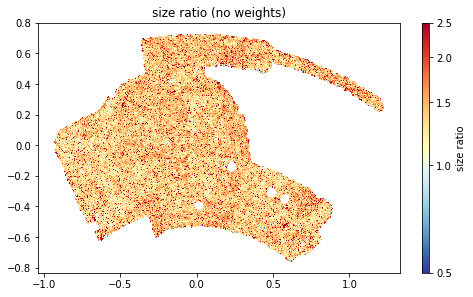

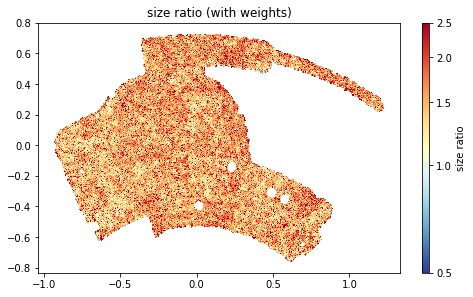

In [47]:
sizz = 7 # size plots 
sel_label = 'metacal' #or all

if sel_label == 'metacal':
    selection_mask = copy.copy(select_metacal)
elif sel_label == 'all':
    selection_mask = copy.copy(select_all)



# Size ratio  (now made with psf_T) ****************************

SR_map = np.zeros(hp.nside2npix(nside))
pix1 = convert_to_pix_coord(ra_master[selection_mask],dec_master[selection_mask], nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
SR_map[unique_pix1] += np.bincount(idx_rep1, weights=size_ratio[selection_mask])

mas_desy3 = desy3_map!=0.
SR_map[mas_desy3] = SR_map[mas_desy3]/desy3_map[mas_desy3]
print(np.mean(SR_map[mas_desy3]))
log_skm_plot(SR_map, ~mas_desy3 , sep=15 , title = 'size ratio (no weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'size ratio', vmin = 0.5, vmax = 2.5,small_scale='True')
plt.savefig('./figures_maps/SR.pdf')


# Size ratio  with weights (now made with psf_T) ****************************


SR_map_w = np.zeros(hp.nside2npix(nside))
pix1 = convert_to_pix_coord(ra_master[selection_mask],dec_master[selection_mask], nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
SR_map_w [unique_pix1] += np.bincount(idx_rep1, weights=(size_ratio*w)[selection_mask])

mas_desy3 = desy3_map!=0.
SR_map_w[mas_desy3] = SR_map_w[mas_desy3]/desy3_map_w[mas_desy3]
print(np.mean(SR_map_w[mas_desy3]))
log_skm_plot(SR_map_w, ~mas_desy3 , sep=15 , title = 'size ratio (with weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'size ratio', vmin = 0.5, vmax = 2.5,small_scale='True')
plt.savefig('./figures_maps/SR_with_weights.pdf')

# sigma_e

/global/u2/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in divide


0.37151782382969695
optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.98675723800992,-35.86924773198294,-57.27828260783114,-11.344402695166536)


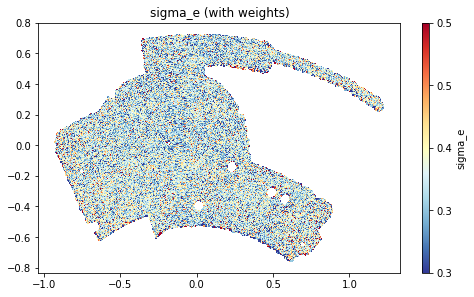

/global/u2/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in divide


0.39709393531164633
optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.98675723800992,-35.86924773198294,-57.27828260783114,-11.344402695166536)


"\nself.sigma_e.append( np.sqrt( (sum_we2_1 / sum_ws**2 + sum_we2_2 / sum_ws**2)\n                              * (sum_w**2 / sum_w2) / 2. ) )\nself.sigma_ec.append( np.sqrt( np.sum( w**2 * (e1**2 + e2**2 - var) )\n                               / ( 2. * sum_w2s2 )\n                              )\n                     )\n\n# Calculate n_eff\nself.neff.append( sum_w**2 / sum_w2 / ( self.area * 60. * 60. ) )\nprint('.......',w,np.sum(mask),sum_w**2,sum_w2,self.area * 60. * 60.,self.area)\nself.neffc.append( ( self.sigma_ec[i]**2 * sum_ws**2 )\n                     / np.sum( w**2 * ( s**2 * self.sigma_ec[i]**2 + var / 2. ) )\n                   / self.area / 60**2\n                  )\n"

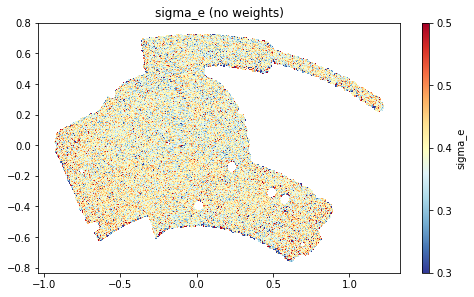

In [55]:
sel_label = 'metacal' #or all

if sel_label =='metacal':
    selection_mask = copy.copy(select_metacal)
    e1 = np.array(master['catalog']['metacal']['unsheared']['e_1'])[selection_mask]  #/R11_1
    e2 = np.array(master['catalog']['metacal']['unsheared']['e_2'])[selection_mask]  #/R22_1
    e1corr= (e1-np.mean(e1))/(R11_1_metacal**2)
    e2corr= (e2-np.mean(e2))/(R22_1_metacal**2)

    e1corr_w= (e1-np.sum(w[selection_mask]*e1)/np.sum(w[selection_mask]))/(R11_1_metacal_w**2)
    e2corr_w= (e2-np.sum(w[selection_mask]*e2)/np.sum(w[selection_mask]))/(R22_1_metacal_w**2)
elif sel_label =='all':
    selection_mask = copy.copy(select_all)
    e1 = np.array(master['catalog']['metacal']['unsheared']['e_1'])[selection_mask]  #/R11_1
    e2 = np.array(master['catalog']['metacal']['unsheared']['e_2'])[selection_mask]  #/R22_1
    e1corr= (e1-np.mean(e1))/(R11_1_all**2)
    e2corr= (e2-np.mean(e2))/(R22_1_all**2)

    e1corr_w= (e1-np.sum(w[selection_mask]*e1)/np.sum(w[selection_mask]))/(R11_1_all_w**2)
    e2corr_w= (e2-np.sum(w[selection_mask]*e2)/np.sum(w[selection_mask]))/(R22_1_all_w**2)
   


sum_we2_2 = np.zeros(hp.nside2npix(nside))
sum_we2_1 = np.zeros(hp.nside2npix(nside))
sum_w2 = np.zeros(hp.nside2npix(nside))
sum_w = np.zeros(hp.nside2npix(nside))



pix1 = convert_to_pix_coord(ra_master[selection_mask],dec_master[selection_mask], nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)

sum_we2_2[unique_pix1] += np.bincount(idx_rep1, weights=(w[selection_mask]*e2corr_w)**2)
sum_we2_1[unique_pix1] += np.bincount(idx_rep1, weights=(w[selection_mask]*e1corr_w)**2)
sum_w2[unique_pix1] += np.bincount(idx_rep1, weights=(w[selection_mask])**2)
sum_w[unique_pix1] += np.bincount(idx_rep1, weights=(w[selection_mask]))

sig_e = np.sqrt((sum_we2_1/sum_w**2+sum_we2_2/sum_w**2)*(sum_w**2/sum_w2)/2.)
#sig_ec = np.sqrt((sum_we2_1/sum_w**2+sum_we2_2/sum_w**2)*(sum_w**2/sum_w2)/2.)
print (np.mean(sig_e[mas_desy3]))
skm_plot(sig_e, ~mas_desy3 , sep=15 , title = 'sigma_e (with weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'sigma_e', vmin = 0.3, vmax = 0.5,small_scale='True')
plt.savefig('./figures_maps/sigma_e_weights.pdf')
plt.show()



sum_we2_2 = np.zeros(hp.nside2npix(nside))
sum_we2_1 = np.zeros(hp.nside2npix(nside))
sum_w2 = np.zeros(hp.nside2npix(nside))
sum_w = np.zeros(hp.nside2npix(nside))



pix1 = convert_to_pix_coord(ra_master[selection_mask],dec_master[selection_mask], nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)

sum_we2_2[unique_pix1] += np.bincount(idx_rep1, weights=(e2corr_w)**2)
sum_we2_1[unique_pix1] += np.bincount(idx_rep1, weights=(e1corr_w)**2)
sum_w2[unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len((w[selection_mask]))))
sum_w[unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len((w[selection_mask]))))

sig_e = np.sqrt((sum_we2_1/sum_w**2+sum_we2_2/sum_w**2)*(sum_w**2/sum_w2)/2.)
#sig_ec = np.sqrt((sum_we2_1/sum_w**2+sum_we2_2/sum_w**2)*(sum_w**2/sum_w2)/2.)
print (np.mean(sig_e[mas_desy3]))
skm_plot(sig_e, ~mas_desy3 , sep=15 , title = 'sigma_e (no weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'sigma_e', vmin = 0.3, vmax = 0.5,small_scale='True')
plt.savefig('./figures_maps/sigma_e.pdf')



'''
self.sigma_e.append( np.sqrt( (sum_we2_1 / sum_ws**2 + sum_we2_2 / sum_ws**2)
                              * (sum_w**2 / sum_w2) / 2. ) )
self.sigma_ec.append( np.sqrt( np.sum( w**2 * (e1**2 + e2**2 - var) )
                               / ( 2. * sum_w2s2 )
                              )
                     )

# Calculate n_eff
self.neff.append( sum_w**2 / sum_w2 / ( self.area * 60. * 60. ) )
print('.......',w,np.sum(mask),sum_w**2,sum_w2,self.area * 60. * 60.,self.area)
self.neffc.append( ( self.sigma_ec[i]**2 * sum_ws**2 )
                     / np.sum( w**2 * ( s**2 * self.sigma_ec[i]**2 + var / 2. ) )
                   / self.area / 60**2
                  )
'''


# mean e1,e2

ValueError: Wrong pixel number (it is not 12*nside**2)

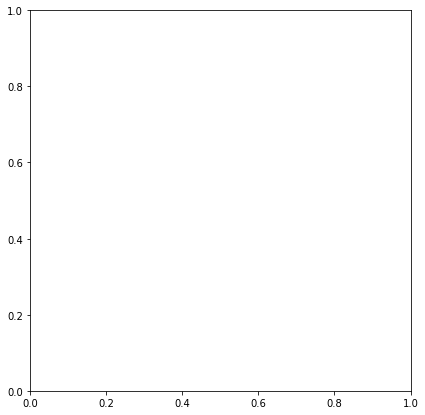

In [56]:
sel_label = 'metacal' #or all

if sel_label =='metacal':
    selection_mask = copy.copy(select_metacal)
    e1 = np.array(master['catalog']['metacal']['unsheared']['e_1'])[selection_mask]  #/R11_1
    e2 = np.array(master['catalog']['metacal']['unsheared']['e_2'])[selection_mask]  #/R22_1
    e1corr= (e1-np.mean(e1))/(R11_1_metacal**2)
    e2corr= (e2-np.mean(e2))/(R22_1_metacal**2)

    e1corr_w= (e1-np.sum(w[selection_mask]*e1)/np.sum(w[selection_mask]))/(R11_1_metacal_w**2)
    e2corr_w= (e2-np.sum(w[selection_mask]*e2)/np.sum(w[selection_mask]))/(R22_1_metacal_w**2)
elif sel_label =='all':
    selection_mask = copy.copy(select_all)
    e1 = np.array(master['catalog']['metacal']['unsheared']['e_1'])[selection_mask]  #/R11_1
    e2 = np.array(master['catalog']['metacal']['unsheared']['e_2'])[selection_mask]  #/R22_1
    e1corr= (e1-np.mean(e1))/(R11_1_all**2)
    e2corr= (e2-np.mean(e2))/(R22_1_all**2)

    e1corr_w= (e1-np.sum(w[selection_mask]*e1)/np.sum(w[selection_mask]))/(R11_1_all_w**2)
    e2corr_w= (e2-np.sum(w[selection_mask]*e2)/np.sum(w[selection_mask]))/(R22_1_all_w**2)
   

e1_map = np.zeros(hp.nside2npix(nside))
e1_map_w = np.zeros(hp.nside2npix(nside))
e2_map = np.zeros(hp.nside2npix(nside))
e2_map_w = np.zeros(hp.nside2npix(nside))

pix1 = convert_to_pix_coord(ra_master[selection_mask],dec_master[selection_mask], nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
e1_map_w[unique_pix1] += np.bincount(idx_rep1, weights=(e1corr_w[selection_mask])
e2_map_w[unique_pix1] += np.bincount(idx_rep1, weights=(e2corr_w[selection_mask])
e1_map[unique_pix1] += np.bincount(idx_rep1, weights=(e1corr[selection_mask])
e2_map[unique_pix1] += np.bincount(idx_rep1, weights=(e2corr[selection_mask])

mas_desy3 = desy3_map!=0.
SR_map_w[mas_desy3] = SR_map_w[mas_desy3]/desy3_map_w[mas_desy3]
e1_map_w[mas_desy3]=e1_map_w[mas_desy3]/desy3_map_w[mas_desy3]
e2_map_w[mas_desy3]=e2_map_w[mas_desy3]/desy3_map_w[mas_desy3]
e1_map[mas_desy3]  =e1_map[mas_desy3]/desy3_map[mas_desy3]
e2_map[mas_desy3]  =e2_map[mas_desy3]/desy3_map[mas_desy3]


skm_plot(e1_map_w, ~mas_desy3 , sep=15 , title = 'e1 (with weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'sigma_e', vmin = -0.1, vmax = 0.1,small_scale='True')
plt.savefig('./figures_maps/e1_weights.pdf')
plt.show()

skm_plot(e1_map, ~mas_desy3 , sep=15 , title = 'e1 (no weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'sigma_e', vmin = -0.1, vmax = 0.1,small_scale='True')
plt.savefig('./figures_maps/e1.pdf')
plt.show()


skm_plot(e1_map_w, ~mas_desy3 , sep=15 , title = 'e2 (with weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'sigma_e', vmin = -0.1, vmax = 0.1,small_scale='True')
plt.savefig('./figures_maps/e2_weights.pdf')
plt.show()

skm_plot(e2corr, ~mas_desy3 , sep=15 , title = 'e2 (no weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'sigma_e', vmin = -0.1, vmax = 0.1,small_scale='True')
plt.savefig('./figures_maps/e2.pdf')
plt.show()


# R Map

In [ ]:
#R map 

# compute response:  **********************
dgamma = 2. * 0.01
R11_1_metacal_a = ((e1p[select_metacal]) - (e1m[select_metacal]) + (
e1[select_metacal_1p]) - (
e1[select_metacal_1m]))/ dgamma
R22_1_metacal_a = ((e2p[select_metacal]) - (e2m[select_metacal]) + (
e2[select_metacal_2p]) - (
e2[select_metacal_2m])) / dgamma


R11_1_all_a = ((e1p[select_all]) - (e1m[select_all]) + (
e1[select_all_1p]) - (
e1[select_all_1m]))/ dgamma
R22_1_all_a = ((e2p[select_all]) - (e2m[select_all]) + (
e2[select_all_2p]) -(
e2[select_all_2m])) / dgamma




In [51]:
# add Y1 and SV outlines 